1. 라이브러리 및 데이터

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import matplotlib
import statsmodels.api as sm
import pylab
import os
import warnings
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson

warnings.filterwarnings("ignore")

plt.rcParams["font.family"]='Malgun Gothic'

matplotlib.rcParams['axes.unicode_minus'] = False

In [2]:
# load data
sleep_data = pd.read_csv(f'{os.getcwd()}/1.Training/원천데이터/2.수면/train_sleep.csv')
sleep_data_label = pd.read_csv(f'{os.getcwd()}/1.Training/라벨링데이터/2.수면/training_label.csv')
sleep_test = pd.read_csv(f'{os.getcwd()}/2.Validation/원천데이터/2.수면/val_sleep.csv')
sleep_test_label = pd.read_csv(f'{os.getcwd()}/2.Validation/라벨링데이터/2.수면/val_label.csv')


In [3]:
# train data 연구 참여자 수: 141 = 85(CN) + 47(MCI) + Dem(9)
# test data 연구 참여자 수: 33 = 26(CN) + MCI(4) + Dem(3)

print(sleep_data.shape)
print(sleep_data_label.shape)
print(sleep_test.shape)
print(sleep_test_label.shape, "\n")
print(sleep_data_label['DIAG_NM'].value_counts(), "\n")
print(sleep_test_label['DIAG_NM'].value_counts())

(9705, 36)
(141, 2)
(2478, 36)
(33, 2) 

DIAG_NM
CN     85
MCI    47
Dem     9
Name: count, dtype: int64 

DIAG_NM
CN     26
MCI     4
Dem     3
Name: count, dtype: int64


In [4]:
def preprocessing(train, label):
    drop_cols = train.describe(include = 'O').columns[1:]
    train = train.drop(drop_cols, axis = 1)
    data = train.groupby('EMAIL').mean().reset_index()
    labeling = dict(np.array(label))

    data['target'] = data['EMAIL'].map(labeling)
    train['target'] = train['EMAIL'].map(labeling)

    # target 변수 numerical data로 변환
    target_dict = {"CN": 1, "MCI": 2, "Dem": 3}
    data['target'] = data['target'].map(target_dict)
    data = data.sort_values(by=['target','EMAIL'], ascending=[True,True])
    data = data.reset_index(drop=True)
    
    train['target'] = train['target'].map(target_dict)
    train = train.sort_values(by=['target','EMAIL'], ascending=[True,True])
    train = train.reset_index(drop=True)

    # Step 1: 'number' 열을 생성 (EMAIL에서 숫자만 추출)
    data['number'] = data['EMAIL'].str.extract(r'(?<=nia\+)(\d+)', expand=False).astype(int)
    train['number'] = train['EMAIL'].str.extract(r'(?<=nia\+)(\d+)', expand=False).astype(int)

    # Step 2: EMAIL 열 삭제
    data.drop(columns=['EMAIL'], inplace=True)
    train.drop(columns=['EMAIL'], inplace=True)

    return data, train

sleep_data_mean, sleep_data_all = preprocessing(sleep_data, sleep_data_label)
sleep_data_all

,sleep_awake,sleep_breath_average,sleep_deep,sleep_duration,sleep_efficiency,sleep_hr_average,sleep_hr_lowest,sleep_is_longest,sleep_light,sleep_midpoint_at_delta,...,sleep_score_disturbances,sleep_score_efficiency,sleep_score_latency,sleep_score_rem,sleep_score_total,sleep_temperature_delta,sleep_temperature_deviation,sleep_total,target,number
0,1860,15.875,5640,24480,92,59.63,54,1,11670,10776,...,79,97,94,72,61,-0.13,-0.13,22620,1,5
1,1860,16.000,9660,31200,94,60.74,53,1,11250,8204,...,80,99,99,99,88,0.11,0.11,29340,1,5
2,3210,15.625,7230,30420,89,61.25,53,1,14100,8574,...,79,95,97,79,79,-0.10,-0.10,27210,1,5
3,1890,16.250,6690,28980,93,60.26,53,1,15750,9217,...,81,99,91,63,79,0.13,0.13,27090,1,5
4,1200,15.875,4980,30180,96,60.71,55,1,18600,8349,...,84,100,72,73,86,-0.41,-0.41,28980,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9700,9480,15.625,3720,46200,79,66.78,60,1,20580,6719,...,56,72,94,100,100,0.41,0.41,36720,3,341
9701,8280,15.000,3480,38280,78,70.26,62,1,18030,3181,...,62,67,99,99,96,0.07,0.07,30000,3,341
9702,2580,17.625,4890,26940,90,69.55,63,1,13470,10501,...,60,96,72,90,74,-0.14,-0.14,24360,3,341
9703,8940,16.625,4470,40860,78,70.85,63,1,18420,5415,...,63,67,97,100,99,0.25,0.25,31920,3,341


In [5]:
print(len(sleep_data_all.columns))

29


In [6]:
# load data
act_data = pd.read_csv(f'{os.getcwd()}/1.Training/원천데이터/1.걸음걸이/train_activity.csv')
act_data_label = pd.read_csv(f'{os.getcwd()}/1.Training/라벨링데이터/1.걸음걸이/training_label.csv')
act_test = pd.read_csv(f'{os.getcwd()}/2.Validation/원천데이터/1.걸음걸이/val_activity.csv')
act_test_label = pd.read_csv(f'{os.getcwd()}/2.Validation/라벨링데이터/1.걸음걸이/val_label.csv')

act_data_mean, act_data_all = preprocessing(act_data, act_data_label)
act_data_all

,activity_average_met,activity_cal_active,activity_cal_total,activity_daily_movement,activity_high,activity_inactive,activity_inactivity_alerts,activity_low,activity_medium,activity_met_min_high,...,activity_score_meet_daily_targets,activity_score_move_every_hour,activity_score_recovery_time,activity_score_stay_active,activity_score_training_frequency,activity_score_training_volume,activity_steps,activity_total,target,number
0,1.46875,314,2071,5849,0,346,0,502,8,0,...,78,100,100,96,100,97,8749,510,1,5
1,1.43750,278,2027,4941,0,427,0,459,7,0,...,60,100,100,91,96,95,7807,466,1,5
2,1.40625,263,2005,5568,0,616,0,302,21,0,...,43,100,100,68,71,79,6954,323,1,5
3,1.37500,238,1961,5110,0,585,0,292,12,0,...,43,100,100,71,71,59,6723,304,1,5
4,1.28125,161,1842,3123,0,496,1,218,10,0,...,25,95,100,81,40,43,4485,228,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9700,1.28125,253,2297,4128,0,403,0,265,11,0,...,43,100,100,91,1,34,5468,276,3,341
9701,1.31250,168,2257,2325,0,624,1,236,4,0,...,43,95,100,66,1,37,3748,240,3,341
9702,1.50000,501,2612,8849,3,330,0,465,26,24,...,60,100,100,99,1,51,10516,494,3,341
9703,1.28125,158,2231,1992,0,621,0,226,1,0,...,43,100,100,65,40,57,3641,227,3,341


In [7]:
# load data
mmse_data = pd.read_csv(f'{os.getcwd()}/1.Training/원천데이터/3.인지기능/train_mmse.csv')
mmse_data_label = pd.read_csv(f'{os.getcwd()}/1.Training/라벨링데이터/3.인지기능/training_label.csv')
mmse_test = pd.read_csv(f'{os.getcwd()}/2.Validation/원천데이터/3.인지기능/val_mmse.csv')
mmse_test_label = pd.read_csv(f'{os.getcwd()}/2.Validation/라벨링데이터/3.인지기능/val_label.csv')

mmse_data

,SAMPLE_EMAIL,DIAG_SEQ,DIAG_NM,DOCTOR_NM,MMSE_NUM,MMSE_KIND,Q01,Q02,Q03,Q04,...,Q14_1,Q14_2,Q15,Q16_1,Q16_2,Q16_3,Q17,Q18,Q19,TOTAL
0,nia+315@rowan.kr,2,CN,-,2,2,2,2,2,2,...,2,2,2,1,2,2,2,2,2,29
1,nia+014@rowan.kr,3,MCI,-,3,2,2,2,2,2,...,2,2,2,1,2,2,2,2,2,28
2,nia+220@rowan.kr,2,CN,-,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,30
3,nia+096@rowan.kr,2,MCI,-,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,27
4,nia+396@rowan.kr,3,CN,-,3,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,nia+181@rowan.kr,1,CN,-,1,2,2,2,2,1,...,2,2,2,2,2,1,2,2,2,26
137,nia+354@rowan.kr,2,CN,-,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,26
138,nia+448@rowan.kr,2,MCI,-,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,28
139,nia+394@rowan.kr,3,CN,-,3,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,28


In [8]:
def mmse_preprocessing(train, label):
    drop_cols = train.describe(include = 'O').columns[1:]
    train = train.drop(drop_cols, axis = 1)
    labeling = dict(np.array(label))

    train['target'] = train['SAMPLE_EMAIL'].map(labeling)

    # target 변수 numerical data로 변환
    target_dict = {"CN": 1, "MCI": 2, "Dem": 3}    
    train['target'] = train['target'].map(target_dict)
    train = train.sort_values(by=['target','SAMPLE_EMAIL'], ascending=[True,True])
    train = train.reset_index(drop=True)

    # Step 1: 'number' 열을 생성 (EMAIL에서 숫자만 추출)
    train['number'] = train['SAMPLE_EMAIL'].str.extract(r'(?<=nia\+)(\d+)', expand=False).astype(int)

    # Step 2: EMAIL 열 삭제
    train.drop(columns=['SAMPLE_EMAIL'], inplace=True)

    return train
mmse_data_mean = mmse_preprocessing(mmse_data, mmse_data_label)
mmse_data_mean

,DIAG_SEQ,MMSE_NUM,MMSE_KIND,Q01,Q02,Q03,Q04,Q05,Q06,Q07,...,Q15,Q16_1,Q16_2,Q16_3,Q17,Q18,Q19,TOTAL,target,number
0,1,1,2,2,2,2,1,2,2,2,...,2,2,2,2,2,2,2,28,1,5
1,4,4,2,2,2,2,2,2,2,2,...,1,1,2,2,2,2,2,26,1,15
2,4,4,2,2,2,2,2,2,2,2,...,1,2,2,2,2,2,2,27,1,21
3,1,1,2,2,2,2,2,2,2,2,...,2,2,2,2,1,2,2,27,1,31
4,2,2,2,2,2,2,2,2,2,2,...,2,1,2,2,2,2,2,28,1,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,1,1,2,2,2,2,1,2,2,2,...,2,1,2,1,2,2,2,23,3,219
137,3,2,2,2,2,1,2,1,2,2,...,2,2,2,1,2,2,2,22,3,230
138,4,3,2,2,2,1,2,2,2,2,...,2,1,2,2,2,2,2,22,3,306
139,4,4,2,2,2,2,2,2,2,2,...,2,1,2,2,2,2,2,27,3,338


In [9]:
data = pd.concat([sleep_data_mean, act_data_mean.loc[:, ~act_data_mean.columns.isin(sleep_data_mean.columns)], mmse_data_mean['TOTAL']], axis=1)
data

,sleep_awake,sleep_breath_average,sleep_deep,sleep_duration,sleep_efficiency,sleep_hr_average,sleep_hr_lowest,sleep_is_longest,sleep_light,sleep_midpoint_at_delta,...,activity_score,activity_score_meet_daily_targets,activity_score_move_every_hour,activity_score_recovery_time,activity_score_stay_active,activity_score_training_frequency,activity_score_training_volume,activity_steps,activity_total,TOTAL
0,2055.663717,16.307522,6152.123894,30115.752212,93.070796,65.231947,57.831858,1.0,16303.539823,11296.017699,...,54.522124,11.601770,95.566372,96.203540,72.088496,6.371681,46.530973,6431.831858,296.955752,28
1,5147.142857,15.725000,8046.857143,28422.857143,81.628571,53.854000,47.885714,1.0,14088.000000,8222.742857,...,79.000000,72.542857,98.571429,99.885714,83.142857,43.628571,62.342857,7211.600000,356.828571,26
2,5435.270270,18.831081,8199.729730,27224.594595,80.648649,68.982838,61.216216,1.0,12606.891892,9204.229730,...,81.891892,84.594595,95.932432,99.770270,60.608108,78.918919,61.945946,5482.216216,289.202703,27
3,8670.379747,16.893987,5886.455696,34593.417722,75.379747,64.707342,58.000000,1.0,14666.202532,32002.139241,...,90.354430,84.341772,96.582278,98.544304,79.962025,87.012658,95.860759,12212.392405,363.544304,27
4,5441.917808,16.964041,4462.191781,30269.589041,82.287671,47.194795,44.835616,1.0,18325.890411,7545.726027,...,94.356164,92.301370,98.712329,99.301370,81.917808,99.890411,95.890411,10369.821918,424.863014,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,7465.227273,19.130682,3139.772727,26896.363636,73.227273,63.036364,57.772727,1.0,14092.500000,7871.818182,...,86.727273,99.545455,97.477273,56.159091,89.000000,100.000000,100.000000,27780.681818,670.363636,23
137,4008.620690,15.393678,7461.034483,36944.827586,89.172414,54.870575,46.942529,1.0,19578.620690,7022.839080,...,78.114943,34.137931,99.195402,99.080460,93.287356,75.965517,90.252874,8476.758621,347.068966,22
138,3726.891892,15.871622,2461.621622,31551.081081,88.581081,54.605135,48.202703,1.0,20261.756757,11127.121622,...,72.824324,45.810811,97.986486,72.148649,80.270270,85.513514,89.243243,7833.621622,210.770270,22
139,3210.000000,17.280738,6413.114754,24405.245902,87.852459,57.650328,53.934426,1.0,14174.262295,9111.327869,...,91.114754,84.032787,99.344262,94.131148,80.032787,99.868852,99.163934,11672.000000,256.000000,27


In [10]:
sleep_test_mean, sleep_test_all = preprocessing(sleep_test, sleep_test_label)
act_test_mean, act_test_all = preprocessing(act_test, act_test_label)
mmse_test_mean = mmse_preprocessing(mmse_test, mmse_test_label)

test = pd.concat([sleep_test_mean, act_test_mean.loc[:, ~act_test_mean.columns.isin(sleep_test_mean.columns)], mmse_test_mean['TOTAL']], axis=1)
test

,sleep_awake,sleep_breath_average,sleep_deep,sleep_duration,sleep_efficiency,sleep_hr_average,sleep_hr_lowest,sleep_is_longest,sleep_light,sleep_midpoint_at_delta,...,activity_score,activity_score_meet_daily_targets,activity_score_move_every_hour,activity_score_recovery_time,activity_score_stay_active,activity_score_training_frequency,activity_score_training_volume,activity_steps,activity_total,TOTAL
0,5478.688525,17.862705,5263.278689,30420.983607,82.081967,69.625738,64.803279,1.0,16088.852459,10423.672131,...,67.491803,29.885246,84.016393,98.540984,61.557377,61.426230,79.180328,6098.868852,224.016393,27
1,6471.428571,14.603571,5471.571429,29982.000000,79.028571,59.682857,53.657143,1.0,14865.857143,7000.085714,...,77.728571,64.514286,99.471429,99.257143,77.914286,44.114286,72.442857,8022.100000,324.285714,29
2,4820.322581,17.521505,4661.612903,28956.129032,83.548387,65.470860,61.462366,1.0,15730.645161,12072.591398,...,88.161290,82.763441,98.322581,99.516129,79.752688,79.193548,86.623656,10066.666667,392.935484,29
3,4333.076923,16.370192,6040.384615,31339.230769,86.205128,63.789872,58.102564,1.0,14514.230769,7070.948718,...,80.846154,58.102564,97.935897,92.987179,74.384615,80.666667,95.038462,7929.025641,268.602564,28
4,3269.565217,16.494565,460.869565,28065.217391,88.376812,67.503188,61.434783,1.0,18560.434783,6552.579710,...,75.173913,75.231884,99.782609,69.188406,83.478261,56.855072,74.463768,11127.072464,435.710145,27
5,5404.125000,16.415625,2014.875000,31218.750000,82.862500,60.411375,55.450000,1.0,18777.750000,6890.537500,...,67.737500,25.875000,92.712500,94.125000,74.025000,59.137500,78.100000,6876.137500,207.187500,30
6,3976.034483,18.075431,7290.000000,29046.206897,86.362069,61.477931,56.620690,1.0,13483.448276,7991.620690,...,92.758621,87.689655,96.068966,97.241379,85.103448,99.017241,96.862069,9939.982759,343.775862,25
7,6001.935484,17.022849,5730.000000,27700.000000,79.698925,61.120108,56.720430,1.0,12682.580645,16926.806452,...,87.784946,89.580645,96.752688,93.193548,82.720430,68.516129,88.838710,8320.827957,361.892473,28
8,7524.117647,17.676471,3385.882353,29705.882353,75.156863,78.902353,72.313725,1.0,12834.117647,14262.862745,...,67.705882,50.274510,75.960784,100.000000,58.156863,36.235294,68.647059,5332.294118,232.980392,29
9,4564.403670,17.493119,7237.981651,26773.761468,83.990826,52.797706,47.972477,1.0,13142.201835,12331.779817,...,89.577982,95.834862,97.119266,82.834862,74.880734,97.770642,97.844037,10401.137615,341.486239,30


2. 변수 선택
- VIF지수 통해 극단적인 변수 삭제
- p value와 correlation 값을 통해 선택한 변수들을 조합

In [129]:
# VIF 계산을 위한 DataFrame 생성
vif_data = pd.DataFrame()
vif_data["Variable"] = data.columns
vif_data["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]

# VIF 값 출력
print(vif_data.sort_values(by='VIF', ascending=False))

# VIF 값이 inf인 변수 & 0 & Nan 제거
high_vif_vars = vif_data[(vif_data['VIF'] == float('inf')) | (vif_data['VIF'] == 0) | (vif_data['VIF'].isna())]['Variable']
print("High VIF Variables: ", high_vif_vars)
print("Nums of High VIF Variables: ", len(high_vif_vars))

                             Variable           VIF
0                         sleep_awake           inf
2                          sleep_deep           inf
3                      sleep_duration           inf
37                    activity_medium           inf
36                       activity_low           inf
33                      activity_high           inf
8                         sleep_light           inf
26                        sleep_total           inf
25        sleep_temperature_deviation           inf
52                     activity_total           inf
24            sleep_temperature_delta           inf
13                          sleep_rem           inf
7                    sleep_is_longest  2.136203e+05
16                        sleep_score  7.481778e+04
23                  sleep_score_total  2.466634e+04
44                     activity_score  1.018729e+04
32            activity_daily_movement  7.521255e+03
22                    sleep_score_rem  5.460354e+03
18          

In [12]:
high_vif_vars_lst = list(high_vif_vars)
new_cols = [i for i in data.columns if i not in high_vif_vars_lst]
new_cols

['sleep_breath_average',
 'sleep_efficiency',
 'sleep_hr_average',
 'sleep_hr_lowest',
 'sleep_is_longest',
 'sleep_midpoint_at_delta',
 'sleep_midpoint_time',
 'sleep_onset_latency',
 'sleep_period_id',
 'sleep_restless',
 'sleep_rmssd',
 'sleep_score',
 'sleep_score_alignment',
 'sleep_score_deep',
 'sleep_score_disturbances',
 'sleep_score_efficiency',
 'sleep_score_latency',
 'sleep_score_rem',
 'sleep_score_total',
 'target',
 'number',
 'activity_average_met',
 'activity_cal_active',
 'activity_cal_total',
 'activity_daily_movement',
 'activity_inactive',
 'activity_inactivity_alerts',
 'activity_met_min_high',
 'activity_met_min_inactive',
 'activity_met_min_low',
 'activity_met_min_medium',
 'activity_non_wear',
 'activity_rest',
 'activity_score',
 'activity_score_meet_daily_targets',
 'activity_score_move_every_hour',
 'activity_score_recovery_time',
 'activity_score_stay_active',
 'activity_score_training_frequency',
 'activity_score_training_volume',
 'activity_steps',
 'TO

In [13]:
def plot_data(df, col):
    plt.figure(figsize=(10, 6))

    plt.subplot(1, 2, 1)
    df[col].hist()

    plt.suptitle(f'{col}')

    plt.subplot(1, 2, 2)

    stats.probplot(df[col], dist='norm', plot=pylab)
    
    plt.show()

In [41]:
# vif지수가 0인 애들은 의미없는 데이터
check_vars = vif_data[vif_data['VIF'] == 0]['Variable']
for col in check_vars:
    plot_data(data, f'{col}')

In [15]:
# vif지수가 nan인 데이터 또한 의미없는 데이터
check_vars2 = vif_data[vif_data['VIF'].isna()]['Variable']
for col in check_vars2:
    plot_data(data, f'{col}')

In [16]:
data_new = data[new_cols]
print(data_new.shape)

(141, 42)


In [17]:
def feature_by_pvalue(df):
    independent_vars = list(df.columns)

    anova_results = {}

    for var in independent_vars:
        group0 = df[df['target'] == 1][var]
        group1 = df[df['target'] == 2][var]
        group2 = df[df['target'] == 3][var]
    
        f_val, p_val = stats.f_oneway(group0, group1, group2)
        anova_results[var] = p_val

    sorted_vars = sorted(anova_results, key=anova_results.get)

    significant_vars = [var for var in sorted_vars if anova_results[var] < 0.05]

    print("유의미한 변수들:", significant_vars)
    print(len(significant_vars))

    return significant_vars

In [18]:
data_for_pvalue = data_new.copy()
data_for_pvalue['target'] = data['target']
cols_by_pvalue = feature_by_pvalue(data_for_pvalue)
print(cols_by_pvalue)

유의미한 변수들: ['target', 'TOTAL', 'number', 'sleep_score_latency', 'sleep_midpoint_time', 'activity_rest', 'activity_score_meet_daily_targets', 'sleep_onset_latency', 'sleep_restless', 'sleep_score_alignment', 'sleep_score_deep', 'activity_score']
12
['target', 'TOTAL', 'number', 'sleep_score_latency', 'sleep_midpoint_time', 'activity_rest', 'activity_score_meet_daily_targets', 'sleep_onset_latency', 'sleep_restless', 'sleep_score_alignment', 'sleep_score_deep', 'activity_score']


In [19]:
cols_by_pvalue.remove('target')
cols_by_pvalue.remove('number')

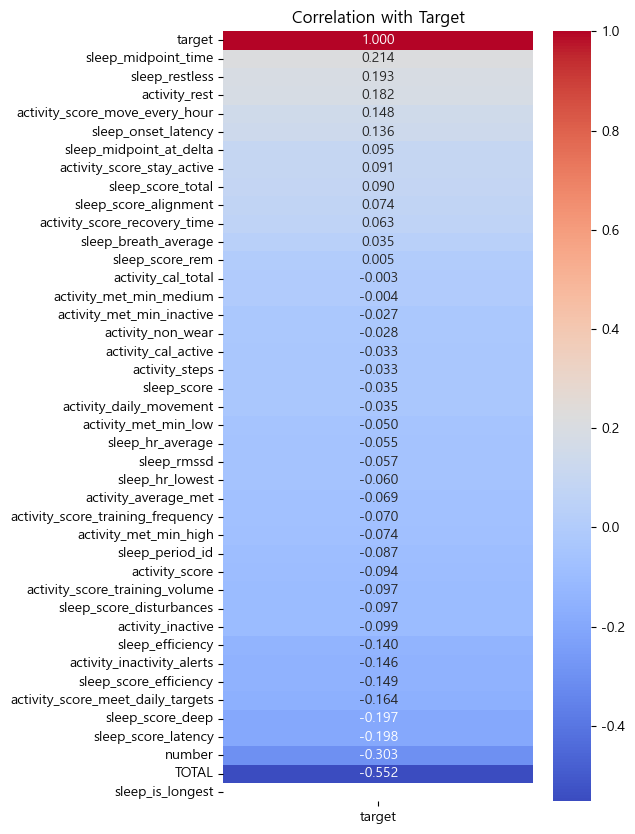

In [20]:
# correlatino으로 variable select
X_train_with_target = data_new.copy()

plt.figure(figsize=(5,10))
sns.heatmap(X_train_with_target.corr()[['target']].sort_values(by='target', ascending=False), annot=True, fmt='.3f',cmap='coolwarm')
plt.title('Correlation with Target')
plt.show()

In [21]:
cols_by_corr = X_train_with_target.columns[abs(X_train_with_target.corr()['target']) >= 0.15].tolist()
cols_by_corr.remove('target')

In [22]:
cols_selected = list(set(cols_by_corr).difference(set(cols_by_pvalue))) + cols_by_pvalue
cols_selected

['number',
 'TOTAL',
 'sleep_score_latency',
 'sleep_midpoint_time',
 'activity_rest',
 'activity_score_meet_daily_targets',
 'sleep_onset_latency',
 'sleep_restless',
 'sleep_score_alignment',
 'sleep_score_deep',
 'activity_score']

In [23]:
cols_selected.remove('number')
data_selected = data[cols_selected]
data_selected

,TOTAL,sleep_score_latency,sleep_midpoint_time,activity_rest,activity_score_meet_daily_targets,sleep_onset_latency,sleep_restless,sleep_score_alignment,sleep_score_deep,activity_score
0,28,83.973451,15127.699115,521.247788,11.601770,672.212389,29.300885,86.849558,89.345133,54.522124
1,26,74.800000,14404.285714,493.057143,72.542857,578.571429,33.571429,89.028571,96.542857,79.000000
2,27,79.905405,13722.972973,430.513514,84.594595,528.243243,32.202703,89.500000,99.081081,81.891892
3,27,84.000000,17314.556962,534.620253,84.341772,817.974684,29.696203,95.430380,92.063291,90.354430
4,28,83.945205,14871.780822,480.698630,92.301370,866.712329,43.602740,99.616438,96.904110,94.356164
...,...,...,...,...,...,...,...,...,...,...
136,23,81.931818,14036.590909,329.772727,99.545455,991.363636,51.931818,89.704545,56.909091,86.727273
137,22,68.609195,18986.896552,690.896552,34.137931,1412.413793,27.850575,99.942529,96.919540,78.114943
138,22,72.878378,15657.972973,684.635135,45.810811,459.729730,46.729730,89.216216,48.081081,72.824324
139,27,81.983607,12480.491803,625.590164,84.032787,641.311475,41.360656,97.737705,94.377049,91.114754


3. Transformation

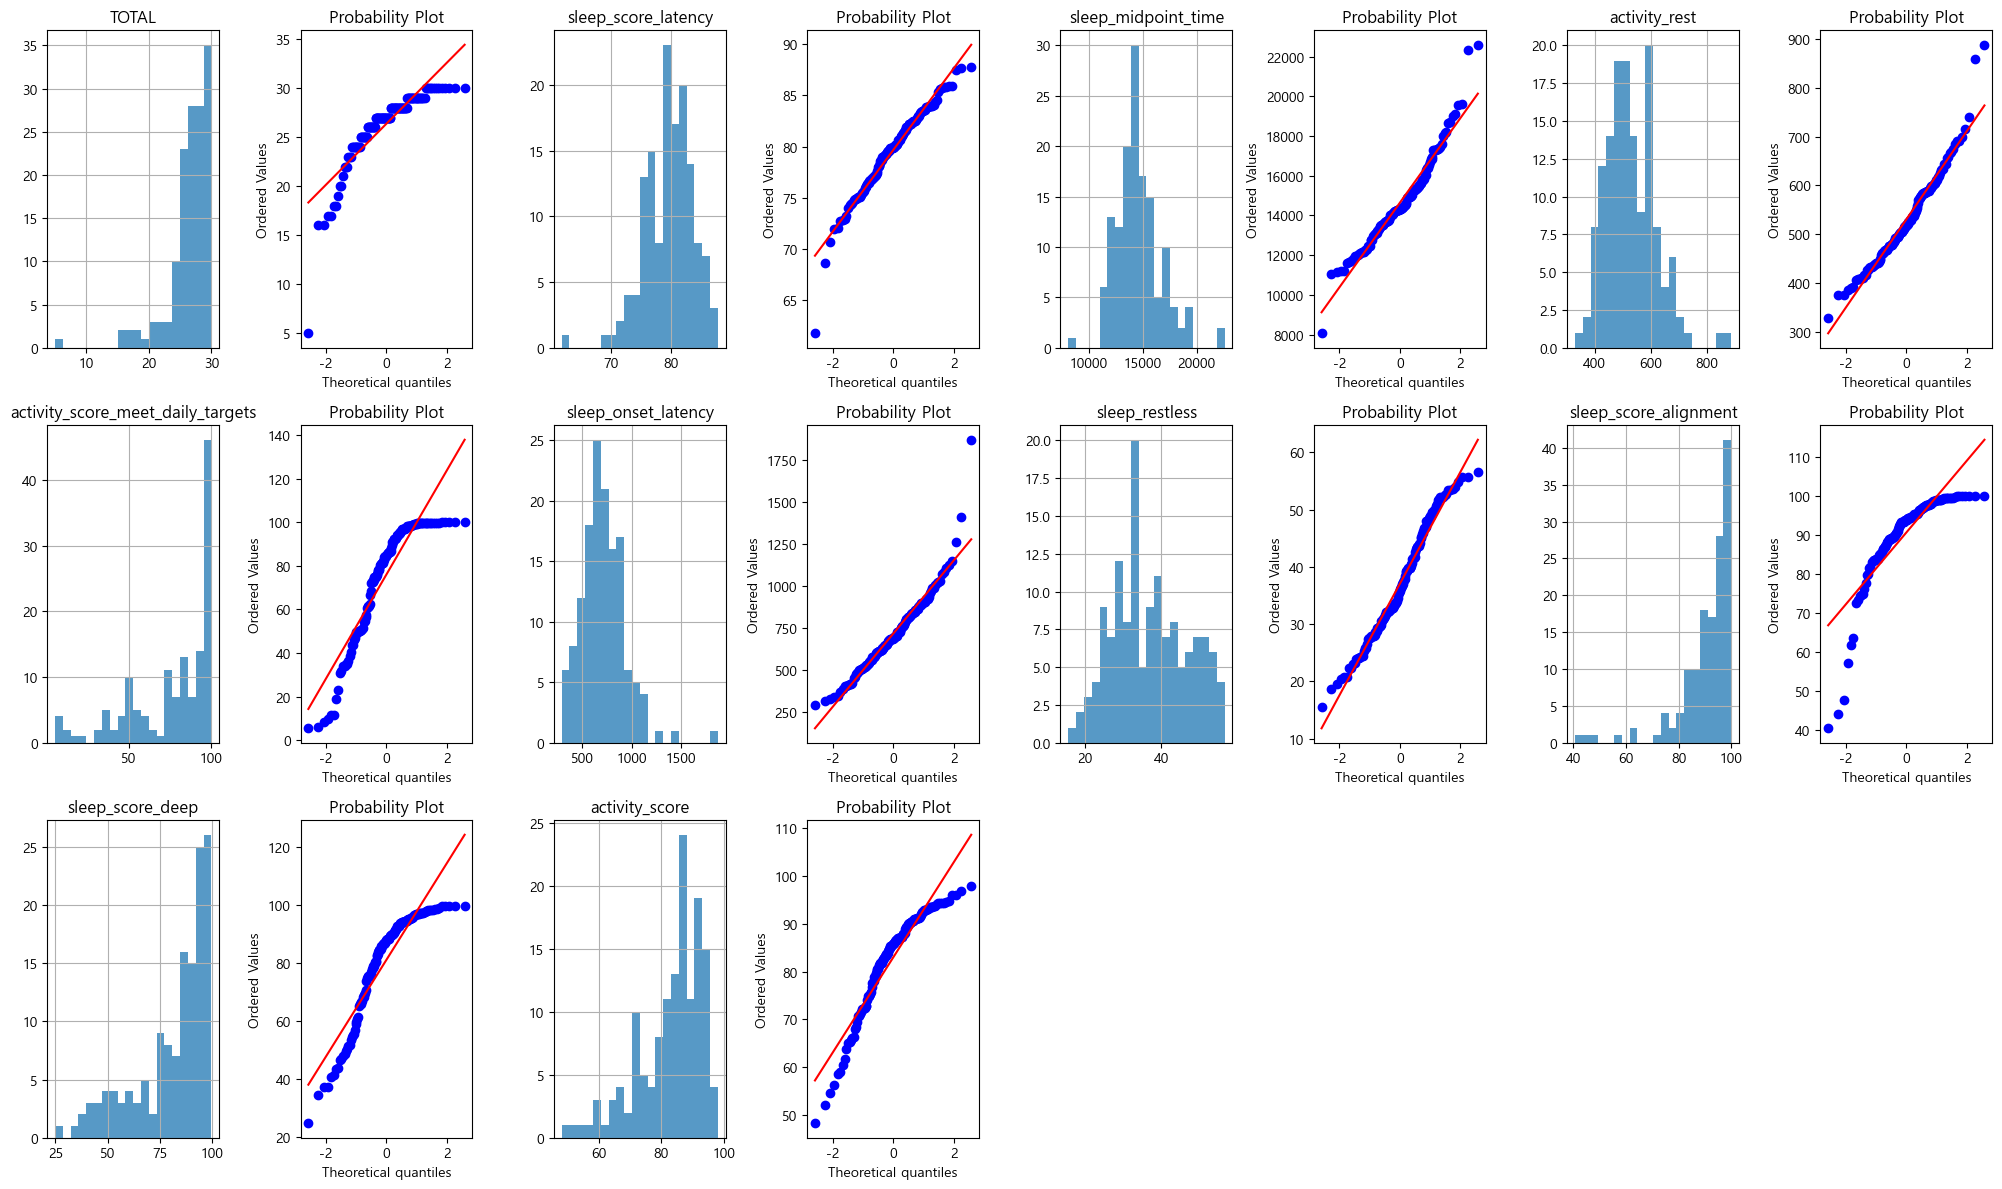

In [24]:
num_cols = 4
num_rows = -(-len(cols_selected) // num_cols)

plt.figure(figsize=(20, num_rows * 4))
for i, col in enumerate(cols_selected, start=1):
    plt.subplot(num_rows, num_cols * 2, 2 * i - 1)
    data[col].hist(bins=20, alpha=0.75)
    plt.title(col)
    plt.tight_layout()

    plt.subplot(num_rows, num_cols * 2, 2 * i)
    stats.probplot(data[col], dist='norm', plot=pylab)
    # plt.title(f'Q-Q Plot of {col}')
    plt.tight_layout()

plt.show()


In [60]:
# 오른쪽으로 크게 치우친 데이터에 대해 square transformation
cols_square = ['TOTAL', 'activity_score_meet_daily_targets', 'sleep_score_deep','sleep_score_alignment', 'activity_score']

In [26]:
# Transformation 변화 확인용
# 실행XXX
# Box-Cox Transformation
#for col in cols_box:
#    X_train_over[f'{col}_box'], _ = stats.boxcox(X_train_over[f'{col}']+1)
#    plot_data(X_train_over, f'{col}_box')
#    plot_data(X_train_over, f'{col}')

- Transformation 비교
    - log, square, box-cox

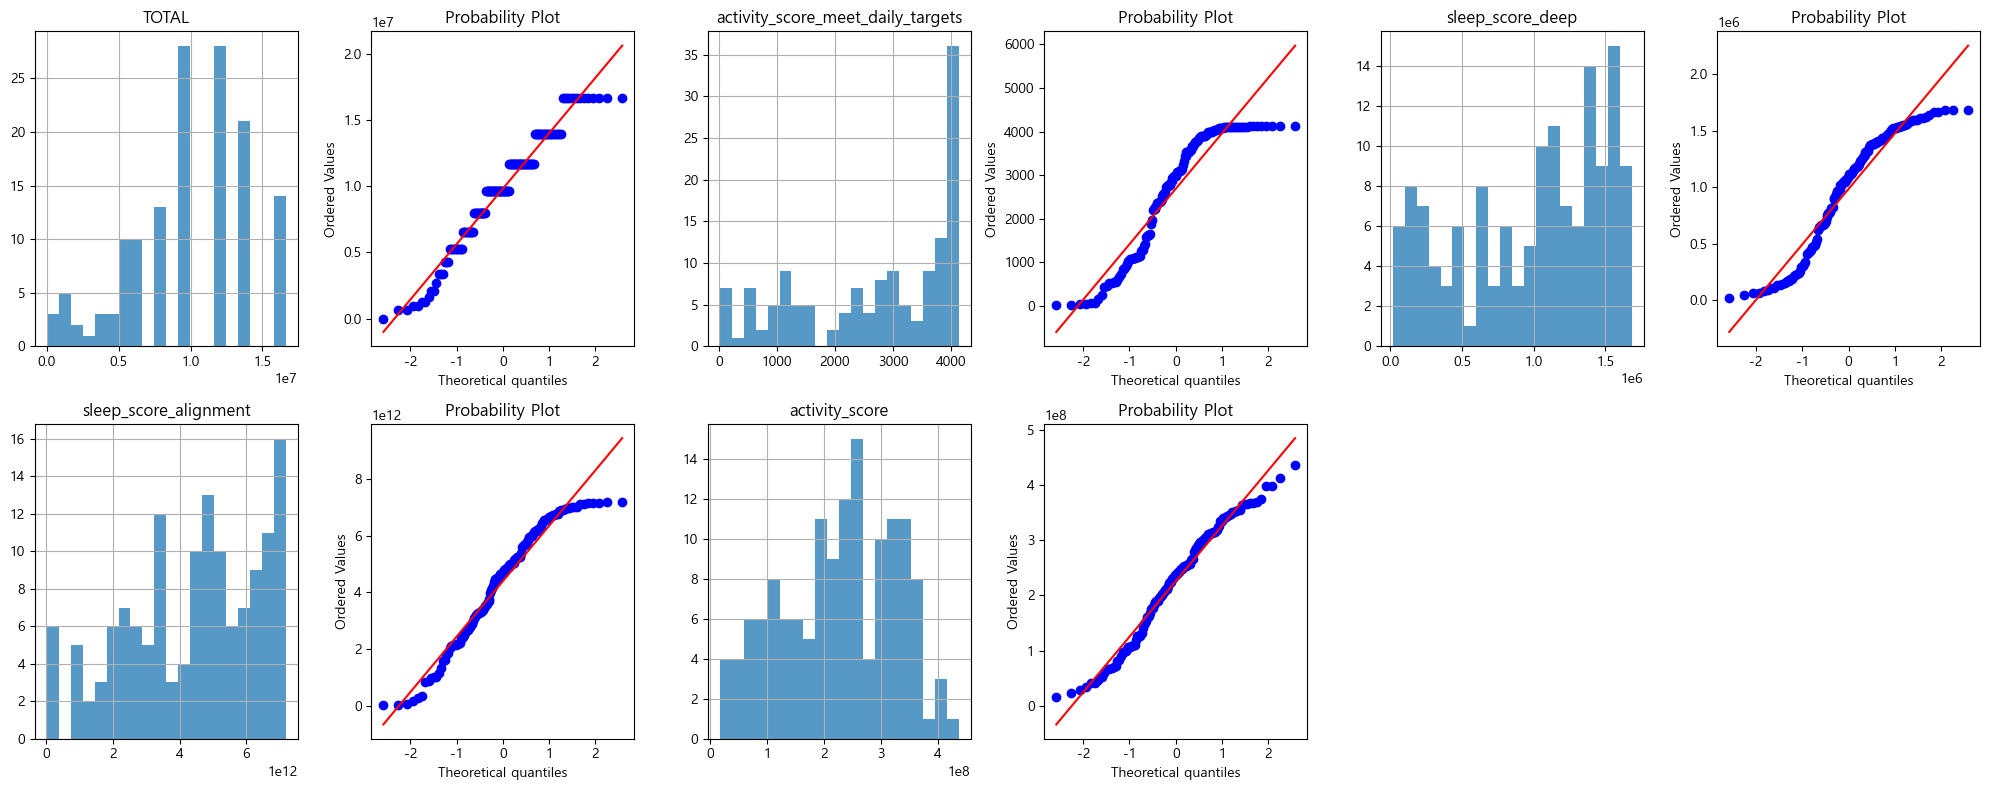

In [77]:
# box-cox transformation
# 다른 변환 방법보다 skewness는 감소하고 가장 정규분포에 가까워 보이지만 실제 모델학습 후 testset에서 모두 치매로 예측함

num_cols = 3
num_rows = -(-len(cols_square) // num_cols)

plt.figure(figsize=(20, num_rows * 4))
for i, col in enumerate(cols_square, start=1):
    data_selected[f'{col}'], _ = stats.boxcox(data[f'{col}']+1)

    plt.subplot(num_rows, num_cols * 2, 2 * i - 1)
    data_selected[col].hist(bins=20, alpha=0.75)
    plt.title(col)
    plt.tight_layout()

    plt.subplot(num_rows, num_cols * 2, 2 * i)
    stats.probplot(data_selected[col], dist='norm', plot=pylab)
    # plt.title(f'Q-Q Plot of {col}')
    plt.tight_layout()

plt.show()


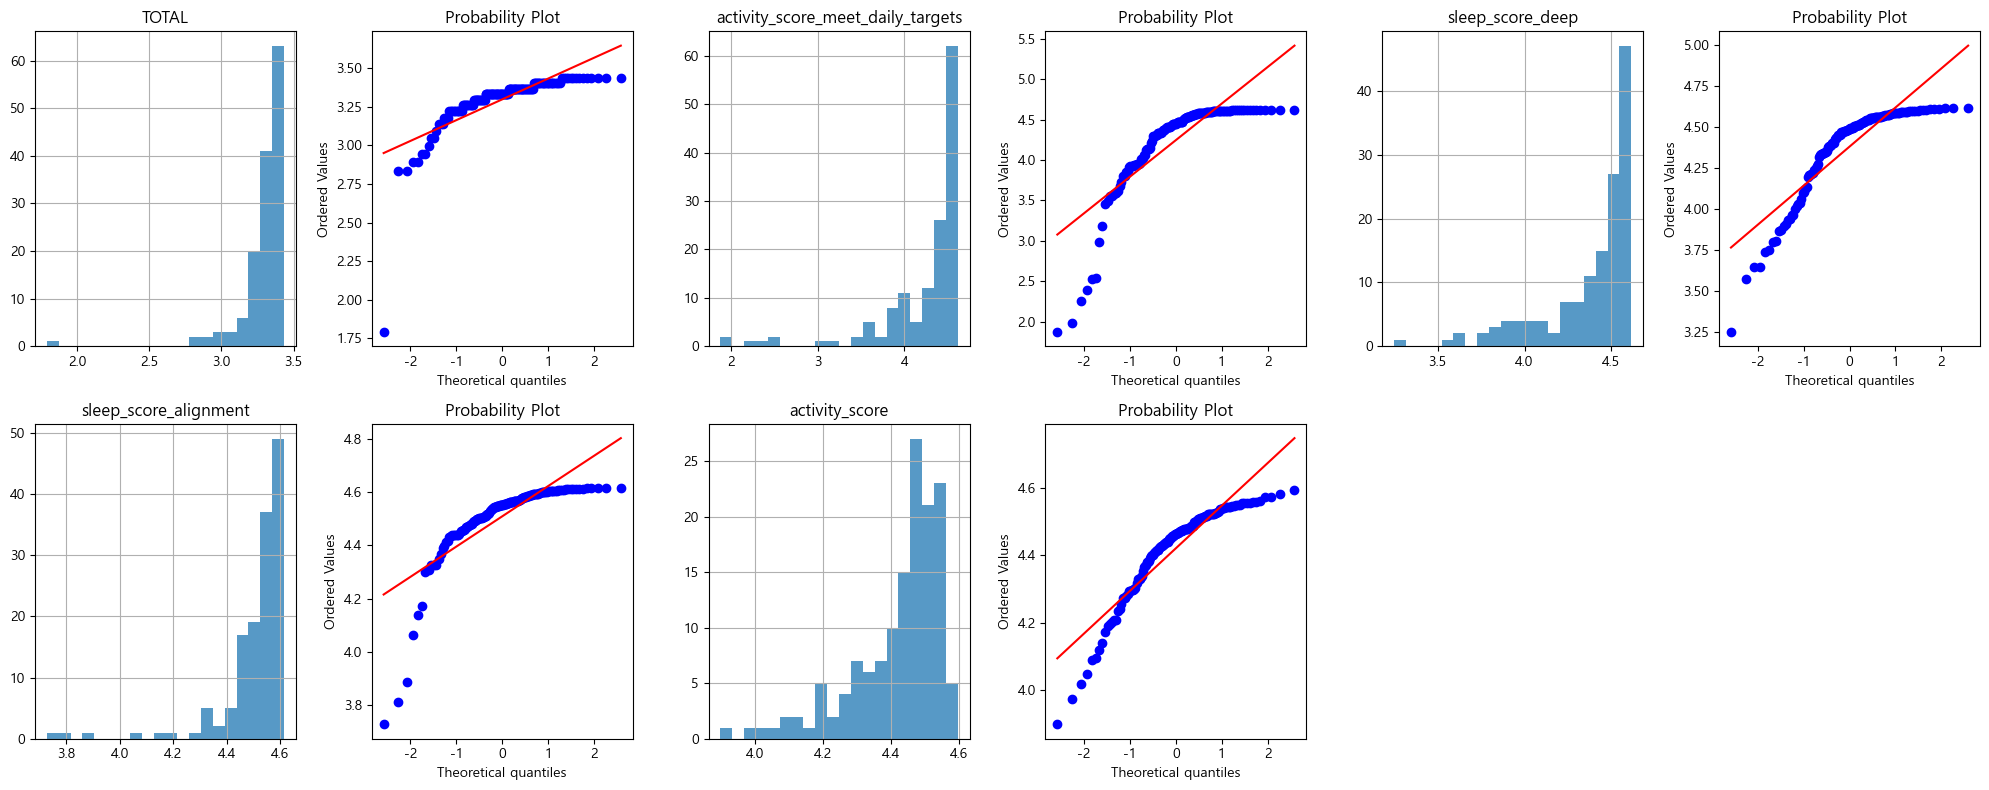

In [ ]:
# log transformation
# 데이터 분포의 왜도가 더 심해보임. 결과는 randomforest 모델 같은 경우 그나마 정확도가 높지만 치매예측정확도는 0임.

num_cols = 3
num_rows = -(-len(cols_square) // num_cols)

plt.figure(figsize=(20, num_rows * 4))
for i, col in enumerate(cols_square, start=1):
    data_selected[f'{col}'] = np.log1p(data[f'{col}'])

    plt.subplot(num_rows, num_cols * 2, 2 * i - 1)
    data_selected[col].hist(bins=20, alpha=0.75)
    plt.title(col)
    plt.tight_layout()

    plt.subplot(num_rows, num_cols * 2, 2 * i)
    stats.probplot(data_selected[col], dist='norm', plot=pylab)
    # plt.title(f'Q-Q Plot of {col}')
    plt.tight_layout()

plt.show()


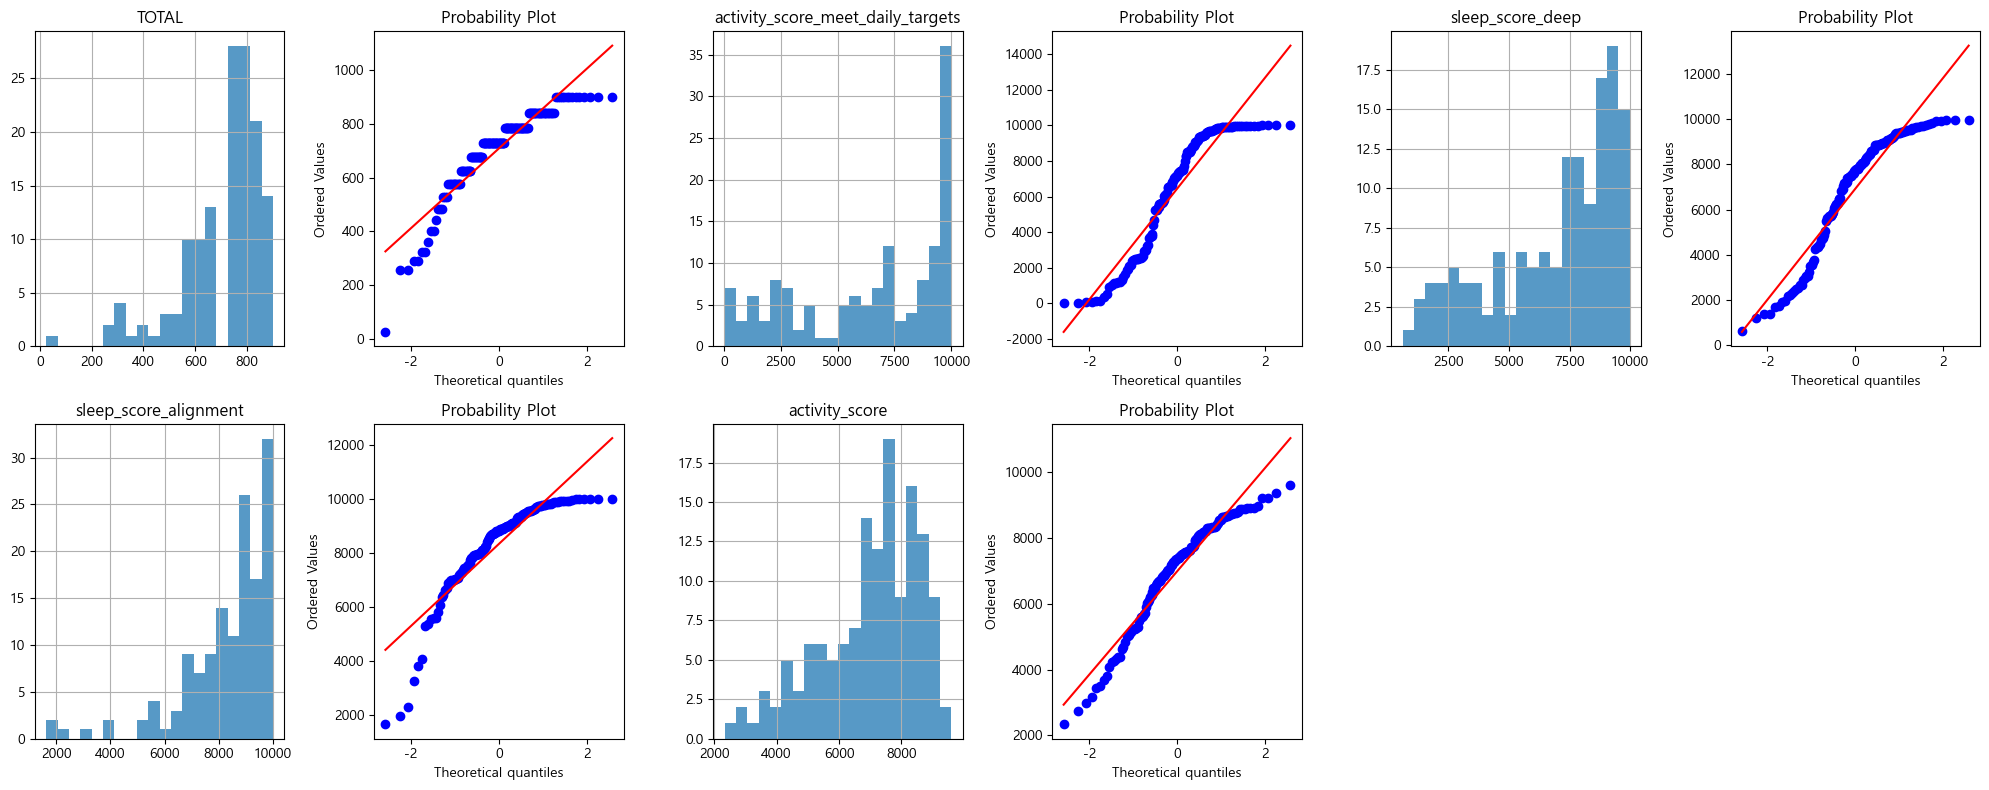

In [111]:
# square transformation

num_cols = 3
num_rows = -(-len(cols_square) // num_cols)

plt.figure(figsize=(20, num_rows * 4))
for i, col in enumerate(cols_square, start=1):
    data_selected[f'{col}'] = np.square(data[f'{col}'])

    plt.subplot(num_rows, num_cols * 2, 2 * i - 1)
    data_selected[col].hist(bins=20, alpha=0.75)
    plt.title(col)
    plt.tight_layout()

    plt.subplot(num_rows, num_cols * 2, 2 * i)
    stats.probplot(data_selected[col], dist='norm', plot=pylab)
    # plt.title(f'Q-Q Plot of {col}')
    plt.tight_layout()

plt.show()


4. Data Train Test Split

In [112]:
# random forest
df = data_selected.copy()
df_target = data_new['target']
print(df_target.shape)
print(df.shape)

(141,)
(141, 10)


In [113]:
X_train,X_val, y_train, y_val = train_test_split(df, df_target, test_size=0.2, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape,"\n")
print(y_train.value_counts(), "\n")
print(y_val.value_counts())

(112, 10)
(112,)
(29, 10)
(29,) 

target
1    70
2    37
3     5
Name: count, dtype: int64 

target
1    15
2    10
3     4
Name: count, dtype: int64


In [114]:
df_test = test[cols_selected]
for col in cols_square:
    df_test[f'{col}'] = np.square(df_test[f'{col}'])
    
df_test_target = test['target']
print(df_test_target.shape)
print(df_test.shape)

(33,)
(33, 10)


5. 데이터 불균형 해결
- SMOTE 기법 (oversampling)

In [115]:
# OVERSAMPLING
smote = SMOTE(random_state=42, k_neighbors=4)
X_train_over, y_train_over= smote.fit_resample(X_train, y_train)
print(f'OVERSAMPLING 적용 후 x train dataset: {X_train_over.shape}')


OVERSAMPLING 적용 후 x train dataset: (210, 10)


6. Scaling

In [116]:
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train_over)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(df_test)
print(X_train_scaled.shape)
print(X_val_scaled.shape)
print(X_test_scaled.shape)

(210, 10)
(29, 10)
(33, 10)


7. 모델 구축 및 평가
- Random Forest
- LightGBM
- SVM

In [117]:
def clf_evaluate(x, y, prob):
    result = pd.DataFrame(dict(accuracy_score = [metrics.accuracy_score(y_true = x, y_pred = y)],
                               precision_score = [metrics.precision_score(y_true = x, y_pred = y, average="weighted")],
                               recall_score = [metrics.recall_score(y_true = x, y_pred = y, average="weighted")],
                               f1_score = [metrics.f1_score(y_true = x, y_pred = y, average="weighted")],
                               roc_auc_score = [metrics.roc_auc_score(y_true = x, y_score = prob, average="weighted", multi_class='ovr')]
                              )
                         )
    return result

def confusion_matrix(x, y):
    return metrics.confusion_matrix(y_true = x, y_pred = y)


- Random Forest

In [118]:
param_grid = {
    'n_estimators': [200, 300],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 4, 8],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=42, class_weight='balanced')
model_rf = GridSearchCV(rf, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)
model_rf.fit(X_train_scaled, y_train_over)

pred_rf = model_rf.predict(X_val_scaled)
pred_proba_rf = model_rf.predict_proba(X_val_scaled)

eval = clf_evaluate(y_val, pred_rf, pred_proba_rf)
confusion_mat = confusion_matrix(y_val, pred_rf)

best_rf = model_rf.best_estimator_
print("Best Parameters:", model_rf.best_params_, "\n")

# 변수 중요도
result_rf = pd.DataFrame(dict(feature = X_train_over.columns,
                              feature_importance = best_rf.feature_importances_))
result_rf.sort_values(by = "feature_importance", ascending = False).head(10)

print(eval)
print(confusion_mat)

Best Parameters: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200} 

   accuracy_score  precision_score  recall_score  f1_score  roc_auc_score
0        0.482759         0.543103      0.482759  0.486737       0.643977
[[6 8 1]
 [3 6 1]
 [0 2 2]]


   accuracy_score  precision_score  recall_score  f1_score  roc_auc_score
0         0.69697         0.827994       0.69697  0.744368       0.753844


<Axes: >

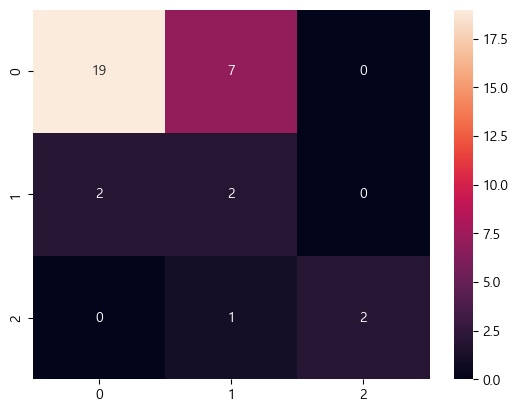

In [119]:
test_pred_rf = model_rf.predict(X_test_scaled)
test_pred_proba_rf = model_rf.predict_proba(X_test_scaled)

test_eval = clf_evaluate(df_test_target, test_pred_rf, test_pred_proba_rf)
test_confusion_mat = confusion_matrix(df_test_target, test_pred_rf)

print(test_eval)
sns.heatmap(test_confusion_mat, annot=True)

- LightGBM

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 676
[LightGBM] [Info] Number of data points in the train set: 210, number of used features: 10
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

<Axes: >

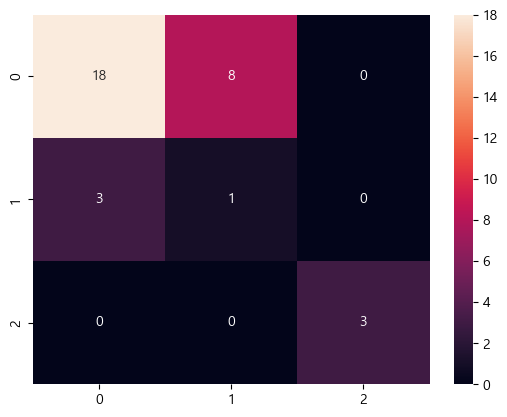

In [120]:
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.02, 0.01],
    'max_depth': [1, 2, 3, 5]
}

lgb_ = lgb.LGBMClassifier(class_weight='balanced',random_state=42, objective='multiclass', num_class=3, metric='multi_logloss')
model_lgb = GridSearchCV(lgb_, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)

evals = [(X_val_scaled, y_val)]
model_lgb.fit(X_train_scaled, y_train_over,
              eval_set=evals, eval_metric='multi_logloss')
test_pred_lgb = model_lgb.predict(X_test_scaled)
test_proba_lgb = model_lgb.predict_proba(X_test_scaled)

test_eval = clf_evaluate(df_test_target, test_pred_lgb, test_proba_lgb)
test_confusion_mat = confusion_matrix(df_test_target, test_pred_lgb)

print("Best Parameters:", model_lgb.best_params_, "\n")
print(test_eval)
sns.heatmap(test_confusion_mat, annot=True)

- SVM

In [121]:
def svc_clf_evaluate(x, y):
    result = pd.DataFrame(dict(accuracy_score = [metrics.accuracy_score(y_true = x, y_pred = y)],
                               precision_score = [metrics.precision_score(y_true = x, y_pred = y, average="weighted")],
                               recall_score = [metrics.recall_score(y_true = x, y_pred = y, average="weighted")],
                               f1_score = [metrics.f1_score(y_true = x, y_pred = y, average="weighted")],
                               )
                         )
    return result

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'C': 1, 'class_weight': 'balanced', 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'} 

   accuracy_score  precision_score  recall_score  f1_score
0        0.787879         0.844909      0.787879  0.810311


<Axes: >

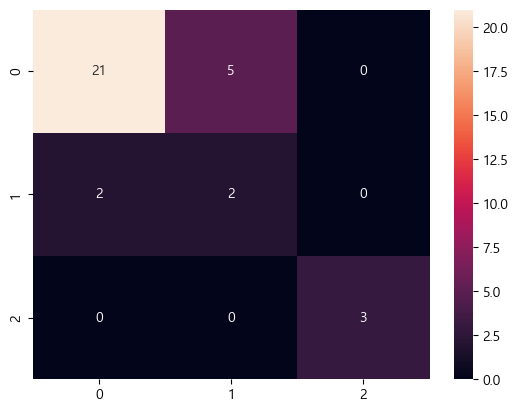

In [122]:
# 변수 추출 이후 사용할 것
param_grid = {
    'C': [ 1],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.1, 0.01],
    'degree': [2, 4],
    'class_weight': ['balanced']
}

model_svc = GridSearchCV(SVC(), param_grid, cv=5, scoring='f1', verbose=1)
model_svc.fit(X_train_scaled, y_train_over)
test_pred_svc = model_svc.predict(X_test_scaled)
cm = confusion_matrix(df_test_target, test_pred_svc)

test_eval = svc_clf_evaluate(df_test_target, test_pred_svc)

print("Best Parameters:", model_svc.best_params_, "\n")
print(test_eval)

sns.heatmap(cm, annot=True)
